# Working with the Review Data

Author: Evan Davis  

Created for: 9/26/2022

This is the second notebook out of two.  

Previous notebook --> `Preparing Data and Scraping.ipynb`

---

## Table of Contents

0. Introduction  
1. Cleaning the Review Data
2. Vectorization of Reviews
3. Fitting a KNN Model
4. Exporting Models

---

## 0. Introduction

In this notebook, we will perform NLP on the reviews scraped from the previous notebook, and use those reviews to build a 'recommendation system' by fitting a KNN model to the vectorized review data. The 'recommendation system' is in quotes because it does not function like a regular recommendation system. This will be further explained later.  

The fitted KNN model and TF-IDF vectorizer will be saved and stored to be used in a Streamlit application.

**Important**: This notebook is run an environment with specific libraries installed. Make sure to create the conda environment to run this notebook using the file `base_env.yml` located in the `environments` folder.

---

## 1. Cleaning the Review Data

First things first, we import all the libraries that we are going to use:

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from langdetect import detect, DetectorFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from nltk.stem import SnowballStemmer
import re
import dill as pickle # for exporting the tfidf without errors

# sets instance for langdetect so that each time it is run, the detected language is consistent
DetectorFactory.seed = 0 # similar to random_state in ML models

Let's read in the reviews from the saved .csv files, as well as the edited top 5,000 data to merge with:

In [2]:
top_edited = pd.read_csv('data/Top5000_edited.csv')
top100 = pd.read_csv('data/top100_reviews.csv')
top200 = pd.read_csv('data/100-200_reviews.csv')
top300 = pd.read_csv('data/200-300_reviews.csv')

In [3]:
top_edited.head()

,Unnamed: 0.1,Unnamed: 0,ars_name,rel_date,gens,descs,avg_rat,num_rat,num_revs,album,...,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,time_signature
0,0,0,radiohead,16 June 1997,"Alternative Rock, Art Rock","melancholic, anxious, futuristic, alienation, ...",4.23,70382,1531,ok-computer,...,0.288083,0.565917,0.161053,0.159375,-9.102417,0.056308,115.450750,0.291733,268435.500000,4.000000
1,1,1,pink-floyd,12 September 1975,"Progressive Rock, Art Rock","melancholic, atmospheric, progressive, male vo...",4.29,48662,983,wish-you-were-here,...,0.373600,0.409800,0.363040,0.384940,-12.689400,0.039740,130.018800,0.259040,530512.000000,3.600000
2,2,2,king-crimson,10 October 1969,"Progressive Rock, Art Rock","fantasy, epic, progressive, philosophical, com...",4.30,44943,870,in-the-court-of-the-crimson-king,...,0.340625,0.370475,0.327265,0.149138,-14.873125,0.043463,118.920625,0.279400,507644.125000,3.875000
3,3,3,radiohead,3 October 2000,"Art Rock, Experimental Rock, Electronic","cold, melancholic, futuristic, atmospheric, an...",4.21,58590,734,kid-a,...,0.601294,0.676706,0.000669,0.311412,-7.811941,0.268318,116.045059,0.398206,325379.529412,4.058824
4,4,4,kendrick-lamar,15 March 2015,"Conscious Hip Hop, West Coast Hip Hop, Jazz Rap","political, conscious, poetic, protest, concept...",4.27,44206,379,to-pimp-a-butterfly,...,0.590750,0.707625,0.000011,0.318419,-5.802062,0.294175,103.444563,0.487187,296225.750000,3.812500


In [4]:
top100.head()

,Unnamed: 0,review,album,rating,user
0,0,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,5.00 stars,Iai
1,1,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,5.00 stars,finulanu
2,2,['I\'d like to think I\'m good about not letti...,ok-computer,4.50 stars,FlintGF
3,3,"[""There are Radiohead devotees like there were...",ok-computer,4.00 stars,seagull59
4,4,['I wrote a shining excellent review for this ...,ok-computer,5.00 stars,Zephos


In [5]:
top200.head()

,Unnamed: 0,review,album,rating,user
0,0,"['', '', '', '', '', '', '', '', '', '', '', '...",odessey-and-oracle,5.00 stars,boundaryfuss
1,1,['It feels me with delight to see two stranger...,odessey-and-oracle,2.50 stars,Vito_James
2,2,"['', '', '', '', '', '', '', '', '', '', '', '...",odessey-and-oracle,4.50 stars,voodookat
3,3,"['', '', '', '', '', '', '', '', '', '', '', '...",odessey-and-oracle,4.50 stars,Decibelle
4,4,"[""Sturdy songs with perfect arrangements. I ne...",odessey-and-oracle,5.00 stars,cavemanpleasures


In [6]:
top300.head()

,Unnamed: 0,review,album,rating,user
0,0,"['', '', '', '', '', '', '', '', '', '', '', '...",a-moon-shaped-pool,5.00 stars,tombnt
1,1,"['', '', '', '', '', '', '', '', '', '', '', ""...",a-moon-shaped-pool,5.00 stars,Aldoooo
2,2,"['', '', '', '', '', '', '', '', '', '', '', '...",a-moon-shaped-pool,4.50 stars,Mr_Crow_TheMusicBird
3,3,['A Moon Shaped Pool (AMSP for sake of my fing...,a-moon-shaped-pool,4.00 stars,GuyWasAssasinated
4,4,"[""Easily Radiohead's most depressing album whi...",a-moon-shaped-pool,4.50 stars,MookidRhubarb


Let's stack the review dataframes vertically so that each row represents a single review:

In [7]:
review_df = pd.concat([top100, top200, top300], axis=0)
review_df

,Unnamed: 0,review,album,rating,user
0,0,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,5.00 stars,Iai
1,1,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,5.00 stars,finulanu
2,2,['I\'d like to think I\'m good about not letti...,ok-computer,4.50 stars,FlintGF
3,3,"[""There are Radiohead devotees like there were...",ok-computer,4.00 stars,seagull59
4,4,['I wrote a shining excellent review for this ...,ok-computer,5.00 stars,Zephos
...,...,...,...,...,...
18946,18946,['Only the first part keeps this from being a ...,flood,5.00 stars,c_deep
18947,18947,"['Get your hands on a copy of this, whatever t...",flood,5.00 stars,gobblox
18948,18948,['Лучший альбом группы. тут они встали точно н...,flood,4.50 stars,Tille
18949,18949,['Hypnotic.'],flood,4.50 stars,kbrooks0o0


Here, we can see that our scraper successfully got 95,239 reviews out of the ~98,000 possible.

Now, we can merge it with the `top5000_edited.csv` data:

In [9]:
total_df = pd.merge(review_df, top_edited, on=['album'], how='left')
total_df.head()

,Unnamed: 0_x,review,album,rating,user,Unnamed: 0.1,Unnamed: 0_y,ars_name,rel_date,gens,...,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,time_signature
0,0,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,5.00 stars,Iai,0,0,radiohead,16 June 1997,"Alternative Rock, Art Rock",...,0.288083,0.565917,0.161053,0.159375,-9.102417,0.056308,115.45075,0.291733,268435.5,4.0
1,1,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,5.00 stars,finulanu,0,0,radiohead,16 June 1997,"Alternative Rock, Art Rock",...,0.288083,0.565917,0.161053,0.159375,-9.102417,0.056308,115.45075,0.291733,268435.5,4.0
2,2,['I\'d like to think I\'m good about not letti...,ok-computer,4.50 stars,FlintGF,0,0,radiohead,16 June 1997,"Alternative Rock, Art Rock",...,0.288083,0.565917,0.161053,0.159375,-9.102417,0.056308,115.45075,0.291733,268435.5,4.0
3,3,"[""There are Radiohead devotees like there were...",ok-computer,4.00 stars,seagull59,0,0,radiohead,16 June 1997,"Alternative Rock, Art Rock",...,0.288083,0.565917,0.161053,0.159375,-9.102417,0.056308,115.45075,0.291733,268435.5,4.0
4,4,['I wrote a shining excellent review for this ...,ok-computer,5.00 stars,Zephos,0,0,radiohead,16 June 1997,"Alternative Rock, Art Rock",...,0.288083,0.565917,0.161053,0.159375,-9.102417,0.056308,115.45075,0.291733,268435.5,4.0


For the model that we are going to fit, we are only going to be using the review itself to predict the album and artist. So, we can just keep only those three columns:

In [13]:
total_df = total_df[['review', 'album', 'ars_name']]
total_df.head()

,review,album,ars_name
0,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,radiohead
1,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,radiohead
2,['I\'d like to think I\'m good about not letti...,ok-computer,radiohead
3,"[""There are Radiohead devotees like there were...",ok-computer,radiohead
4,['I wrote a shining excellent review for this ...,ok-computer,radiohead


When running the scraper, we noticed that there were some albums that didn't get the reviews scraped. Thus, there are some rows with NaNs for their `review` column. This is because of the way that the scraper was set up: if the scraper went to a url that returned a 404 error, it put in a NaN as a review for the album and went on to the next album. Let's see how many times that happened:

In [14]:
total_df.isna().sum()

review      19
album        0
ars_name     0
dtype: int64

There's 19 missing albums out of 300! While this is about ~6% of the albums missing, it isn't as bad as it sounds. We still have 95,000 reviews out of the possible 98,000! Let's change our data frame to exclude the albums that couldn't have their reviews scraped:

In [16]:
total_df = total_df[total_df['review'].isna() == False]
total_df

,review,album,ars_name
0,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,radiohead
1,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,radiohead
2,['I\'d like to think I\'m good about not letti...,ok-computer,radiohead
3,"[""There are Radiohead devotees like there were...",ok-computer,radiohead
4,['I wrote a shining excellent review for this ...,ok-computer,radiohead
...,...,...,...
95234,['Only the first part keeps this from being a ...,flood,boris
95235,"['Get your hands on a copy of this, whatever t...",flood,boris
95236,['Лучший альбом группы. тут они встали точно н...,flood,boris
95237,['Hypnotic.'],flood,boris


Let's check the NaN counts to make sure that that worked:

In [17]:
total_df.isna().sum()

review      0
album       0
ars_name    0
dtype: int64

Success!  

Now, let's remove non-english reviews. If you want to be extra robust in including as much data as possible, you could translate every non-english review into english. However, for the sake of feasability within in a limited time frame, we will just exclude non-english reviews.  

Unforutnately, the package we use to detect language requires strings, and can't work with data frames. We could use the .apply function to a dataframe instead of looping over every review, but it's not really any faster than a for loop since it actually works like a for loop in the source code.

First, we create our `lang` column to store the detected language:

In [18]:
# Create empty column first
total_df['lang'] = 0

Let's run a quick test to see if we can detect the language of the review correctly

In [21]:
start = time.time()

try:
    total_df['lang'][12345] = detect(total_df['review'][12345])
except:
    total_df['lang'][12345] = np.nan

print(f'It took {round(time.time()-start, 2)} seconds to detect the language')

It took 0.01 seconds to detect the language


Doesn't take very long at all to detect the language of a review. Now, for all 95,000 reviews, this might take a little bit longer:

In [22]:
# This is to supress the warning that gets raised; this loop will show the warning many times otherwise
pd.options.mode.chained_assignment = None 

start = time.time()

for i in range(total_df.shape[0]):
    try:
        total_df['lang'][i] = detect(total_df['review'][i])
    except:
        total_df['lang'][i] = np.nan
    if i % 5000 == 0:
        print(f'It took {round(time.time()-start, 2)} seconds to get through review # {i}')

It took 0.02 seconds to get through review # 0
It took 34.23 seconds to get through review # 5000
It took 65.82 seconds to get through review # 10000
It took 99.64 seconds to get through review # 15000
It took 134.33 seconds to get through review # 20000
It took 167.83 seconds to get through review # 25000
It took 201.57 seconds to get through review # 30000
It took 235.7 seconds to get through review # 35000
It took 270.25 seconds to get through review # 40000
It took 303.84 seconds to get through review # 45000
It took 337.27 seconds to get through review # 50000
It took 371.29 seconds to get through review # 55000
It took 407.11 seconds to get through review # 60000
It took 441.8 seconds to get through review # 65000
It took 476.93 seconds to get through review # 70000
It took 511.25 seconds to get through review # 75000
It took 548.14 seconds to get through review # 80000
It took 584.0 seconds to get through review # 85000
It took 618.92 seconds to get through review # 90000
It too

Since we used a try and except clause, let's see if the loop caught any failures that were saved as NaNs:

In [23]:
total_df.isna().sum()

review       0
album        0
ars_name     0
lang        45
dtype: int64

Yup, 45 reviews couldn't get their language detected. We need to exclude those:

In [24]:
total_df = total_df[total_df['lang'].isna() == False]

Now, we can save the data frame with the newly made `lang` column into a .csv file so that we can reference it without having to run that loop again:

In [25]:
total_df.to_csv('data/reviews_w_lang.csv')
total_df.head()

,review,album,ars_name,lang
0,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,radiohead,en
1,"['', '', '', '', '', '', '', '', '', '', '', '...",ok-computer,radiohead,en
2,['I\'d like to think I\'m good about not letti...,ok-computer,radiohead,en
3,"[""There are Radiohead devotees like there were...",ok-computer,radiohead,en
4,['I wrote a shining excellent review for this ...,ok-computer,radiohead,en


---

## 2. Vectorization of Reviews

With all of the processing out of the way, let's make sure to take only the enlgish reviews to form the final data frame that we are going to be selecting our independent and dependent variables from:

In [2]:
total_df = pd.read_csv('data/reviews_w_lang.csv')
total_df = total_df[total_df['lang'] == 'en']
total_df.shape

(85406, 5)

There's now 85,406 english reviews compared to the ~95,000 total reviews we have before!

We can now set our independent variable as the review and the dependent variable as the album:

In [3]:
# Independent Variable
X = total_df['review']

# Dependent Variable
y = total_df['album']

**NOTE**: We need to work with a sample of the data here! This is because if we use all ~85,000 reviews to vectorize, we end up with a data frame that takes up around 180 GB of memory! Obviously, most local systems cannot handle this amount of memory usage. If you have the financial backing or access to a cloud computing service that provides a system that can handle that much memory, then you may want to consider using all possible reviews, as this will give a more robust model fit.  

However, we will proceed with the sample of the data for computational efficienty/feasability.

In [4]:
# Need to stratify split to preserve distribution of occurances of classes (albums)
X_rem, X_sample, y_rem, y_sample = train_test_split(X, y, stratify=y, test_size=0.1, random_state=123)

Let's just check the frequencies of classes across the original and sample data to make sure that this split works for taking a  sample:

In [5]:
y.value_counts(normalize=True)

ok-computer                                0.016802
the-dark-side-of-the-moon                  0.014624
loveless                                   0.013172
revolver                                   0.012915
the-beatles-white-album                    0.011767
                                             ...   
donkey-kong-country-2-diddys-kong-quest    0.000176
the-end-of-evangelion                      0.000105
mingus-ah-um                               0.000094
symphonie-nr_5                             0.000059
atrocity-exhibition                        0.000047
Name: album, Length: 281, dtype: float64

In [6]:
y_sample.value_counts(normalize=True)

ok-computer                                0.016860
the-dark-side-of-the-moon                  0.014635
loveless                                   0.013230
revolver                                   0.012879
the-beatles-white-album                    0.011825
                                             ...   
the-nocturnes                              0.000117
donkey-kong-country-2-diddys-kong-quest    0.000117
mingus-ah-um                               0.000117
the-end-of-evangelion                      0.000117
twin-peaks-fire-walk-with-me               0.000117
Name: album, Length: 279, dtype: float64

Frequencies seem to be good. Let's see exactly how many reviews we are now working with in our sample data:

In [7]:
X_sample.shape

(8541,)

Now, we have a much more manageable 8,541 reviews to vectorize!  

Let's see what each review actually looks like:

In [8]:
X_sample

12875    ['reckoner is luminous beyond understanding\n\...
26356    ['Side 1 is one of my favorite album sides, bu...
44136    ["SO, the first few tracks of this album reall...
90086    ['My favorite RUSH album. Perfect in every way.']
1924     ["I had to replace my copy of WYWH due to dama...
                               ...                        
47338    ['', '', '', '', '', '', "Zappa himself, ... w...
38162    ["It starts here. The Beatles' tearing down of...
83889    ['', '', '', '', '', '', '', '', '', '', 'Nick...
55357    ["Wow, this album is fucking awesome. I used t...
37619    ['', '', '', '', '', '', '', '', '', '', '', '...
Name: review, Length: 8541, dtype: object

There are a few things of note when looking at the reviews:
- indicies are all jumbled
- should deal with capitalization
- should account for mentions of the class (album) itself when trying to predict class
- need to deal with punctuation in reviews

So, let's start with fixing the indicies for both X and y:

In [9]:
X_sample.reset_index(inplace=True, drop=True)
X_sample.head()

0    ['reckoner is luminous beyond understanding\n\...
1    ['Side 1 is one of my favorite album sides, bu...
2    ["SO, the first few tracks of this album reall...
3    ['My favorite RUSH album. Perfect in every way.']
4    ["I had to replace my copy of WYWH due to dama...
Name: review, dtype: object

In [10]:
y_sample.reset_index(inplace=True, drop=True)
y_sample.head()

0           in-rainbows
1                   low
2             rain-dogs
3       moving-pictures
4    wish-you-were-here
Name: album, dtype: object

Then, we can make every review lowercase so that capitalization isn't taken into account by our vectorizer:

In [11]:
X_sample = X_sample.str.lower()
X_sample[0]

"['reckoner is luminous beyond understanding\\n\\nthe rest of the album is on a much lower level but still pretty amazing, except for faust arp and house of cards']"

Now, we need to remove any mention of album name. If left in, the model we fit could use a mention of the album itself to predict which album the review belongs to, which would sort of be cheating. So we remove any mentions of the album in the review:

In [12]:
start = time.time()
for i in range(X_sample.shape[0]):
    
    X_sample[i] = X_sample[i].replace(f'{y_sample[i]}', ' ')
    print(f"Removed album mentions in review #{i+1}", end='\r')
    
print(f'\nAlbum names removed in {round(time.time()-start, 2)} seconds')

Removed album mentions in review #2534

Removed album mentions in review #5194

Removed album mentions in review #7671

Removed album mentions in review #8541
Album names removed in 1.26 seconds


In order to deal with punctuation, we define a function with multiple uses. This function will: 
- remove punctuation 
- tokenize the text
- stem the text

Tokenizing must be done in order to stem the words. Stemming the words generalizes the words in the text so that suffixes and conjugations of certain words are removed and grouped into the same word (doing --> do, done --> do) to reduce redundancy.

In [13]:
def stem_tokenizer(text):
    
    stemmer = SnowballStemmer('english')
    words = re.sub("[^A-Za-z0-9\-]", " ", text) # removes all punctuation (can't use str.replace like before cause it's not a pandas dataframe)
    words = words.split() # makes all words lowercase, tokenizes words
    words = [stemmer.stem(word) for word in words]
    
    return words

Now, we are ready to fit our TF-IDF vectorizer (using our customer stemmer and tokenizer) to the review data:

In [14]:
# 1. Instantiate
tfidf = TfidfVectorizer(stop_words='english', tokenizer=stem_tokenizer) # using english stopwords and our defined tokenizer

# 2. Fit
tfidf_fit = tfidf.fit(X_sample)

# 3. Transform data
review_tfidf = tfidf_fit.transform(X_sample)

C:\Users\evanm\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\evanm\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'w

In [15]:
review_tfidf.shape

(8541, 28016)

We have weights for 28,016 words across 8,541 reviews! As mentioned before, if we did not use a sample of the data, and vectorized all ~85,000 reviews, we would have weights for approximately 100,000 words! Trying to convert this 85,000 x 100,000 matrix into a pandas data frame to work with would have taken up 180 GB of memory! Good thing we're working with a sample of the data.

Let's see which words have the most impact on predicting which album the review is associated with:

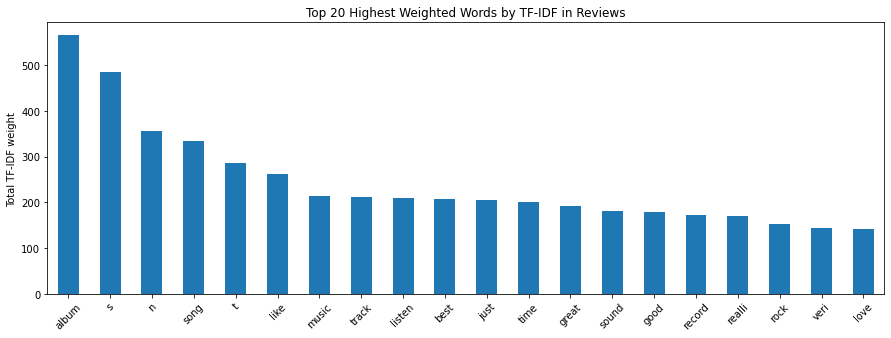

In [17]:
word_weights = pd.DataFrame(
    {"weights": review_tfidf.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("weights", ascending=False)

word_weights.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 Highest Weighted Words by TF-IDF in Reviews")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

In [21]:
word_weights.index

Index(['album', 's', 'n', 'song', 't', 'like', 'music', 'track', 'listen',
       'best',
       ...
       '3-1', 'piston', 'judaism', 'deedeede', 'susten', 'schiff',
       'double-entendr', 'thermopyla', 'reinvok', 'conjoin'],
      dtype='object', length=28016)

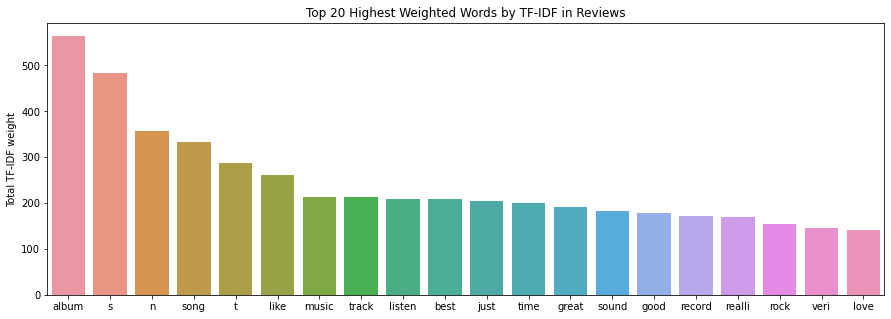

In [26]:
word_weights = word_weights.head(20)

plt.figure(figsize=(15, 5))
sns.barplot(x=word_weights.index, y='weights', data=word_weights)
plt.title("Top 20 Highest Weighted Words by TF-IDF in Reviews")
plt.ylabel("Total TF-IDF weight")
plt.show()

There are some interesting insights here! First off, we can see that our stemmer's method of dealing with punctuation wasn't very friendly to contractions (don't, he's wasn't, etc). The s, n, and t were left on their own and ended up being common enough to appear on the highest weighted words list. We can also see that very commonly used words when discussing music are appearing. Words such as album, song, music, track, and listen are generic words when talking about music, but they appear very frequently. There are a few positive descriptors in here as well, such as great, good, and love. This is probably because the reviews we are looking at are for the top 300 albums of all time according to rateyourmusic.com. So, we would expect to see a lot of praise in these reviews.

Let's save the words from the TF-IDF vectorizer:

In [44]:
words = tfidf.get_feature_names_out()

---

## 3. Fitting a KNN Model

We are going to fit a KNN model to our vectorized data. We choose a KNN because we want to find a review most similar to the input (which will be a review), and return the associated album. A KNN model chooses the closest item in a multi-dimensional space and returns the class of the item. So, this model would be a good measure of which album the inputted text best describes.

First, we eed to split the data into train/validation sets:

In [45]:
X_train, X_validation, y_train, y_validation = train_test_split(review_tfidf, y_sample, test_size=0.3, random_state=123)

Note that we cannot stratify using y_sample. This is because there are as few as 1 occurance for some of the y classes (albums), and you cannot stratify when there is only 1 occurance of a class. This problem could be alleviated if we didn't have to take a sample of the data, but technological limitations force us down this path.

We condense the split TF-IDF matricies into pandas data frames to be used for the model:

In [21]:
X_train = pd.DataFrame(X_train.todense(), columns=words)
X_validation = pd.DataFrame(X_validation.todense(), columns=words)

In [22]:
X_train

,-,--,---,----,-----,------,-------,------------,---------------------------,----------------------------------,...,zowe,zu,zulu,zum,zuma,zumbi,zvala,zwt4n8p,zxxzooz,zzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we are ready to run our first KNN model:

In [47]:
# Instantiate
knn = KNeighborsClassifier()

# Fit 
knn.fit(X_train, y_train)

# Score on train/validation
print(f'Train score: {knn.score(X_train, y_train)}')
print(f'Validation score: {knn.score(X_validation, y_validation)}')

Train score: 0.6615925058548009
Validation score: 0.462738977760437


If we were to choose a review and assign an album to it randomly, we certainly would not have nearly a 46% success rate at assigning the correct album that the review was written about. That means that our model is performing quite well!

Let's try to optimize our model by varying the n_neighbors parameter:

In [48]:
train_scores = []
validation_scores = []
ks = range(1,11)

for k in ks:
    
    start = time.time()
    
    # Instantiate
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit 
    knn.fit(X_train, y_train)

    # Score on train/validation
    train_scores.append(knn.score(X_train, y_train))
    validation_scores.append(knn.score(X_validation, y_validation))
    
    print(f'Loop # {k} completed in {round(time.time()-start, 2)} seconds')

Loop # 1 completed in 2.83 seconds
Loop # 2 completed in 2.75 seconds
Loop # 3 completed in 2.83 seconds
Loop # 4 completed in 3.09 seconds
Loop # 5 completed in 3.11 seconds
Loop # 6 completed in 3.14 seconds
Loop # 7 completed in 3.1 seconds
Loop # 8 completed in 4.07 seconds
Loop # 9 completed in 3.18 seconds
Loop # 10 completed in 3.22 seconds


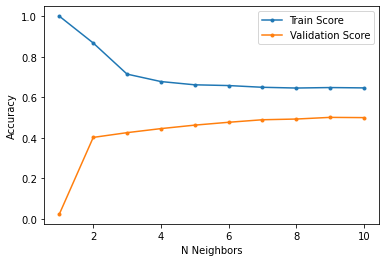

In [49]:
plt.figure()
plt.plot(ks, train_scores, label="Train Score", marker='.')
plt.plot(ks, validation_scores, label="Validation Score", marker='.')
plt.xlabel('N Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Looks like around the K value of 9 is where the train and validation scores begin to level out. So, we will use K=9 for our KNN model:

In [51]:
# Instantiate
knn = KNeighborsClassifier(n_neighbors=9)

# Fit 
knn_fit = knn.fit(X_train, y_train)

# Score on train/validation
print(f'Train score: {knn.score(X_train, y_train)}')
print(f'Validation score: {knn.score(X_validation, y_validation)}')

Train score: 0.6480428236868518
Validation score: 0.5009754194303551


What would our predictions look like with this model?:

In [52]:
y_pred = knn_fit.predict(X_validation)

In [53]:
pd.DataFrame({'Predicted Album': y_pred, 'Actual Album': y_validation})

,Predicted Album,Actual Album
1188,the-beatles-white-album,the-beatles-white-album
6421,led-zeppelin,led-zeppelin
7437,agaetis-byrjun,spiderland
4370,in-rainbows,in-rainbows
1108,in-the-aeroplane-over-the-sea,songs-in-the-key-of-life
...,...,...
61,forca-bruta,if-youre-feeling-sinister
1798,master-of-puppets,master-of-puppets
5115,raw-power,fun-house
28,out-to-lunch,out-to-lunch


Let's try writing a description of our own of a piece of music, and see which album the model predicts is best represented by the input!

In [54]:
input_review = "It's electronic, glitchy, and fun. I love the wall of sound that the music creates!"

Need to transform the input:

In [55]:
input_transformed = tfidf_fit.transform(pd.Series(input_review))

Now we can predict:

In [56]:
knn_fit.predict(input_transformed)[0] # this is how we have to access the album output

'agaetis-byrjun'

We have a functioning 'recommender system'!  

As mentioned at the beginning of the notebook, this is not a typical recommender system. This is a KNN model that tries to predict the album that a particular review is writing about. We are using the KNN prediction to determine which album should be recommended to a person by identifying which album in our database is best described by the description the user gave for what they like about a different piece of music.

Let's flesh out the input and recommendation:

In [57]:
input_review = input("Write a small blurb about why you like a certain piece of music (without explicitly naming the piece or artist) or just explain which kind of music you're looking for! We'll give you an album to check out! \n")

Write a small blurb about why you like a certain piece of music (without explicitly naming the piece or artist) or just explain which kind of music you're looking for! We'll give you an album to check out! 
I want to listen to something warm, cozy, and comforting


In [58]:
input_review = str(input_review)

input_transformed = tfidf_fit.transform(pd.Series(input_review))

recommend_album = knn_fit.predict(input_transformed)[0]

recommend_artist = total_df[total_df['album'] == f'{recommend_album}']['ars_name'].unique()[0]

recommend_album = recommend_album.replace('-', ' ')
recommend_album = recommend_album.replace('_', ' ')
recommend_album = recommend_album.title()

recommend_artist = recommend_artist.replace('-', ' ')
recommend_artist = recommend_artist.replace('_', ' ')
recommend_artist = recommend_artist.title()

print(f"We recommend the album '{recommend_album}' by {recommend_artist}")

We recommend the album 'Heaven Or Las Vegas' by Cocteau Twins


With that, we have a fleshed out 'recommendation system'!

---

## 4. Exporting Models

To save the fitted KNN model and TF-IDF vectorizer, we will use the Pickle library. An alternative to this is the Joblib library. Joblib tends to handle large arrays more efficiently than Pickle, but we are only exporting models, so we can use the pickle library that comes included with python. However, as seen in the library imports, we are using a library called Dill. It is built off Pickle and has the same functionality. It allows the TF-IDF we have fit to be saved without having to refit the TF-IDF to data everytime we want to use it.  

These two models are used to create the Streamlit application that can be found in the same directory as this notebook titled `recommender.py`. To run this Streamlit application, you must navigate to the directory where you saved `recommender.py` and run the command `streamlit run recommender.py` in the git terminal with the `base_env` environment activated.

In [59]:
pickle.dump(knn_fit, open('models/knn_model.sav', 'wb'))
pickle.dump(tfidf_fit, open('models/tfidf.sav', 'wb'))

---